<a href="https://colab.research.google.com/github/Prachii26/DeepLearningCMPE258/blob/main/AI%20Coding%20Tools/multimodal-latest-model-demo/multimodal_use_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %%
# Setup: minimal installs
import sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])

pip_install(["google-genai", "Pillow", "matplotlib", "numpy"])


In [ ]:
# %% [markdown]
# # 🚀 Gemini + DeepSeek ML Demo Notebook
# **Setup**: installs, imports, API keys, folder helpers

# %%
# ---------- INSTALL ----------
!pip install -q google-genai pillow requests

# ---------- IMPORTS ----------
import os, json, time, uuid, zipfile, textwrap, base64
from pathlib import Path
from datetime import datetime
from typing import Any, Optional, Union

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from io import BytesIO

# Optional (only used if you later keep HF router code)
try:
    from huggingface_hub import InferenceClient as HFInferenceClient
except Exception:
    HFInferenceClient = None

# ---------- API KEYS ----------
def get_secret(name: str) -> Optional[str]:
    """Read from env var first, then Colab Secrets."""
    v = os.environ.get(name)
    if v:
        return v
    try:
        from google.colab import userdata  # type: ignore
        v = userdata.get(name)
        if v:
            return v
    except Exception:
        pass
    return None

GEMINI_API_KEY   = get_secret("GEMINI_API_KEY")
DEEPSEEK_API_KEY = get_secret("DEEPSEEK_API_KEY")  # optional

if not GEMINI_API_KEY:
    raise RuntimeError(
        "❌ Missing GEMINI_API_KEY. Set env var GEMINI_API_KEY or add a Colab Secret named GEMINI_API_KEY."
    )

print("✅ GEMINI_API_KEY loaded.")
print(f"{'✅' if DEEPSEEK_API_KEY else '⚠️  (optional)'} DEEPSEEK_API_KEY: "
      f"{'loaded' if DEEPSEEK_API_KEY else 'not set — will use fallback where needed'}.")

# ---------- INIT GEMINI CLIENT ----------
from google import genai
from google.genai import types

gemini = genai.Client(api_key=GEMINI_API_KEY)

# ---------- OUTPUT FOLDERS ----------
OUT_DIR    = Path("outputs")
IMAGES_DIR = OUT_DIR / "images"
VIDEOS_DIR = OUT_DIR / "videos"
JSON_DIR   = OUT_DIR / "json"

def ensure_dirs() -> None:
    for d in (IMAGES_DIR, VIDEOS_DIR, JSON_DIR):
        d.mkdir(parents=True, exist_ok=True)

ensure_dirs()
print("📁 Output folders ready:", [str(d) for d in (IMAGES_DIR, VIDEOS_DIR, JSON_DIR)])
print("📁 Output root:", OUT_DIR.resolve())

# ---------- HELPERS ----------
def unique_path(dir_path: Path, prefix: str, ext: str) -> Path:
    ts = time.strftime("%Y%m%d_%H%M%S")
    uid = uuid.uuid4().hex[:8]
    return dir_path / f"{prefix}_{ts}_{uid}.{ext.lstrip('.')}"

def save_text(text: str, path: Union[str, Path]) -> Path:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding="utf-8")
    print(f"  💾 Saved text  → {path}")
    return path

def save_json(data: Any, path: Union[str, Path]) -> Path:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    if isinstance(data, str):
        try:
            parsed = json.loads(data)
            path.write_text(json.dumps(parsed, indent=2, ensure_ascii=False), encoding="utf-8")
        except Exception:
            path.write_text(data, encoding="utf-8")
    else:
        path.write_text(json.dumps(data, indent=2, ensure_ascii=False), encoding="utf-8")
    print(f"  💾 Saved JSON  → {path}")
    return path

def save_bytes(b: bytes, path: Union[str, Path]) -> Path:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_bytes(b)
    print(f"  💾 Saved bytes → {path}")
    return path

def save_pil_image(img: Image.Image, path: Union[str, Path]) -> Path:
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    img_to_save = img if img.mode in ("RGB", "RGBA") else img.convert("RGB")
    img_to_save.save(path)
    print(f"  💾 Saved image → {path}")
    return path

# Back-compat alias used by some of your sections
def save_image(img: Image.Image, name: str) -> Path:
    return save_pil_image(img, IMAGES_DIR / name)

def save_video(data: bytes, name: str) -> Path:
    return save_bytes(data, VIDEOS_DIR / name)

# Show either a path or a PIL image (handles both of your older call styles)
def show_image(x: Union[Path, str, Image.Image], title: Optional[str] = None) -> None:
    if isinstance(x, (str, Path)):
        img = Image.open(x).convert("RGB")
    else:
        img = x.convert("RGB")
    plt.figure(figsize=(8, 5))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=11)
    plt.tight_layout()
    plt.show()

print("✅ Setup complete.")


✅ GEMINI_API_KEY loaded.
⚠️  (optional) DEEPSEEK_API_KEY: not set — will use fallback where needed.
📁 Output folders ready: ['outputs/images', 'outputs/videos', 'outputs/json']
📁 Output root: /content/outputs
✅ Setup complete.


In [ ]:
# %%
# FINAL FIX for Section A (FREE/local): use stable Diffusers+Transformers pins that still include FLAX_WEIGHTS_NAME
# This avoids your "cannot import name FLAX_WEIGHTS_NAME" error.

import sys, subprocess, importlib

def pip(cmd):
    print(">", " ".join([sys.executable, "-m", "pip"] + cmd))
    subprocess.check_call([sys.executable, "-m", "pip"] + cmd)

# Clean reinstall with compatible versions
pip(["uninstall", "-y", "diffusers", "transformers", "tokenizers"])
pip(["install", "-q", "--no-cache-dir",
     "transformers==4.41.2",
     "tokenizers==0.19.1",
     "diffusers==0.30.0",
     "accelerate",
     "safetensors"
])

# Clear cached imports
for m in list(sys.modules.keys()):
    if m.startswith(("diffusers", "transformers", "tokenizers")):
        sys.modules.pop(m, None)
importlib.invalidate_caches()

from diffusers import StableDiffusionXLPipeline
print("✅ Imports OK:", StableDiffusionXLPipeline)


> /usr/bin/python3 -m pip uninstall -y diffusers transformers tokenizers
> /usr/bin/python3 -m pip install -q --no-cache-dir transformers==4.41.2 tokenizers==0.19.1 diffusers==0.30.0 accelerate safetensors
✅ Imports OK: <class 'diffusers.pipelines.stable_diffusion_xl.pipeline_stable_diffusion_xl.StableDiffusionXLPipeline'>


🖥️ Device: cuda


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]


🎨 bioluminescent_forest
  💾 outputs/images/bioluminescent_forest_214244.png

🎨 steampunk_library
  💾 outputs/images/steampunk_library_214245.png

🎨 underwater_city_rush_hour
  💾 outputs/images/underwater_city_rush_hour_214246.png


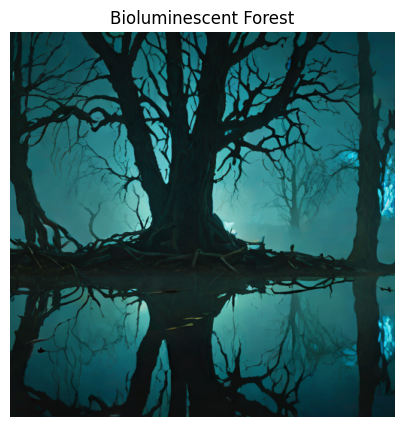

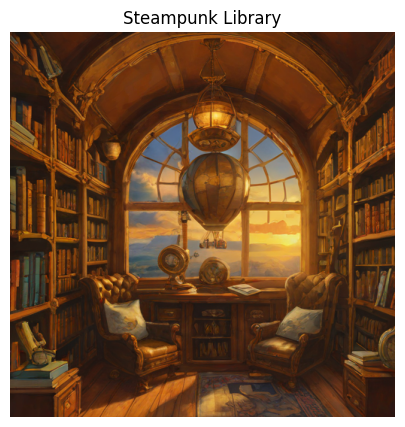

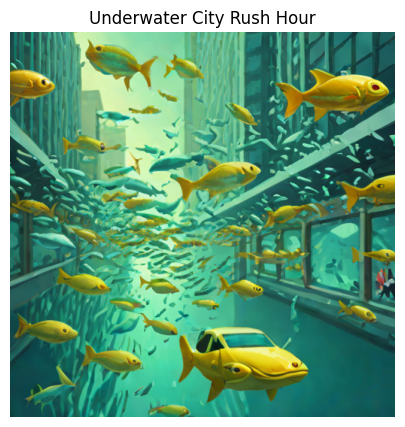

✅ Section A done.


In [ ]:
# %%
# Now run SDXL-Turbo generation (FREE/local)

import torch
from datetime import datetime
from pathlib import Path
from PIL import Image
import numpy as np
from diffusers import StableDiffusionXLPipeline

OUT_DIR = Path("outputs")
IMAGES_DIR = OUT_DIR / "images"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

PROMPTS = [
    ("bioluminescent_forest",
     "Cinematic wide shot of an ancient forest at midnight, every organism glowing bioluminescent blue and gold, "
     "massive tree roots over a still black mirror lake, lone fox at water's edge, volumetric fog, ultra-realistic, IMAX quality"),
    ("steampunk_library",
     "Interior of a Victorian steampunk library inside a hot-air balloon gondola above storm clouds at sunset, "
     "brass gears on bookshelves, mechanical owl on a globe, warm amber lantern light, detailed oil painting style"),
    ("underwater_city_rush_hour",
     "Underwater metropolis rush hour, schools of fish replacing cars in gridlock, jellyfish as traffic lights, "
     "manta ray as city bus with commuters, photorealistic, dappled caustic light from surface, depth of field blur"),
]

def make_placeholder(prompt: str, size=(768, 512)) -> Image.Image:
    import textwrap as tw
    rng = np.random.default_rng(abs(hash(prompt)) % (2**31))
    arr = np.zeros((size[1], size[0], 3), dtype=np.uint8)
    c1 = rng.integers(30, 120, 3).astype(float)
    c2 = rng.integers(80, 220, 3).astype(float)
    for y in range(size[1]):
        f = y / size[1]
        arr[y] = (c1 * (1 - f) + c2 * f).astype(np.uint8)
    img = Image.fromarray(arr)
    from PIL import ImageDraw, ImageFont
    draw = ImageDraw.Draw(img)
    try:
        font  = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 18)
        small = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 13)
    except Exception:
        font = small = ImageFont.load_default()
    draw.text((20, 20), "⚠️  IMAGE GENERATION UNAVAILABLE", fill=(255, 220, 50), font=font)
    wrapped = tw.fill(f'Prompt: "{prompt[:220]}"', width=72)
    draw.multiline_text((20, 60), wrapped, fill=(180, 255, 180), font=small, spacing=4)
    return img

def save_image(img: Image.Image, name: str) -> Path:
    p = IMAGES_DIR / name
    img.convert("RGB").save(p)
    print("  💾", p)
    return p

def show_image(path: Path, title: str):
    import matplotlib.pyplot as plt
    im = Image.open(path).convert("RGB")
    plt.figure(figsize=(8, 5))
    plt.imshow(im)
    plt.axis("off")
    plt.title(title)
    plt.show()

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🖥️ Device:", device)

pipe = None
if device == "cuda":
    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/sdxl-turbo",
        torch_dtype=torch.float16,
        variant="fp16",
    ).to("cuda")
    pipe.set_progress_bar_config(disable=True)
else:
    print("⚠️ No GPU detected — using placeholders.")

paths = []
for name, prompt in PROMPTS:
    print("\n🎨", name)
    if pipe is None:
        img = make_placeholder(prompt)
    else:
        gen = torch.Generator(device="cuda").manual_seed(abs(hash(prompt)) % (2**31))
        img = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0.0, generator=gen).images[0]
    ts = datetime.now().strftime("%H%M%S")
    p = save_image(img, f"{name}_{ts}.png")
    paths.append((p, name))

for p, name in paths:
    show_image(p, name.replace("_", " ").title())

print("✅ Section A done.")


In [ ]:
# %% [markdown]
# ## Section B: Text → Video (ZeroScope v2 — free open-source AI model)
# Model: cerspense/zeroscope_v2_576w  (diffusers, runs on Colab free T4 GPU)
# No API key, no credits, no billing required.
# ⚠️  Requires GPU runtime: Runtime → Change runtime type → T4 GPU

# %%
!pip install -q diffusers transformers accelerate imageio[ffmpeg]

import torch
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video

OUTPUTS      = Path("outputs")
IMG_DIR      = OUTPUTS / "images"
VID_DIR      = OUTPUTS / "videos"
JSON_DIR     = OUTPUTS / "json"

# ---------- CHECK GPU ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️  Device: {device}")
if device == "cpu":
    print("⚠️  No GPU detected — switch to Runtime → Change runtime type → T4 GPU")
    print("   Video generation will be very slow on CPU (~20 min per video).")

# ---------- LOAD MODEL ----------
print("\n📦 Loading ZeroScope v2 576w (downloading ~3.7GB on first run) ...")
pipe = DiffusionPipeline.from_pretrained(
    "cerspense/zeroscope_v2_576w",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()   # streams layers to CPU to save VRAM
pipe.enable_vae_slicing()         # reduces peak VRAM usage further
print("✅ Model loaded.")

# ---------- PROMPTS ----------
VIDEO_PROMPTS = [
    {
        "name": "aurora_timelapse",
        "prompt": (
            "timelapse of northern lights aurora borealis over frozen lake at night, "
            "green and purple lights reflecting on ice, cinematic, 4K, high quality"
        ),
        "negative": "blurry, watermark, text, low quality, distorted",
    },
    {
        "name": "coral_reef_bloom",
        "prompt": (
            "underwater coral reef at sunrise, colorful fish swimming through coral arches, "
            "golden light rays from surface, photorealistic, nature documentary style"
        ),
        "negative": "blurry, watermark, text, low quality, distorted",
    },
]

# ---------- GENERATE ----------
video_output_paths = []

for item in VIDEO_PROMPTS:
    print(f"\n🎬 Generating: {item['name']} ...")
    print("   (16 frames @ 576x320 — ~2–4 min on T4 GPU) ...")

    try:
        with torch.inference_mode():
            output = pipe(
                item["prompt"],
                negative_prompt=item["negative"],
                num_inference_steps=25,   # lower = faster, less quality
                height=320,
                width=576,
                num_frames=16,
            )
        frames = output.frames[0]   # list of PIL Images

        # Save as MP4
        fname    = f"{item['name']}_{datetime.now().strftime('%H%M%S')}.mp4"
        out_path = str(VID_DIR / fname)
        export_to_video(frames, out_path, fps=8)

        size_kb = Path(out_path).stat().st_size // 1024
        print(f"  ✅ Saved → {out_path}  ({size_kb} KB, {len(frames)} frames)")
        video_output_paths.append(Path(out_path))

    except Exception as e:
        print(f"  ❌ Generation failed: {e}")
        # Save stub so outputs/videos is never empty
        stub = {
            "status": "FAILED", "error": str(e),
            "model": "cerspense/zeroscope_v2_576w",
            "prompt": item["prompt"],
            "fix": "Ensure T4 GPU runtime is selected in Colab.",
        }
        stub_path = VID_DIR / f"{item['name']}_error.json"
        stub_path.write_text(json.dumps(stub, indent=2))
        video_output_paths.append(stub_path)

# ---------- DISPLAY first frame of each video ----------
print(f"\n🖼️  Preview (first frame of each generated video):\n")
for p in video_output_paths:
    if str(p).endswith(".mp4"):
        try:
            import imageio.v3 as iio
            frames_preview = iio.imread(str(p), plugin="pyav")
            plt.figure(figsize=(8, 4.5))
            plt.imshow(frames_preview[0])
            plt.axis("off")
            plt.title(
                f"{p.stem}  — ZeroScope v2 AI  |  {len(frames_preview)} frames  "
                "(download to play full video)",
                fontsize=9
            )
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"  ⚠️  Preview failed: {e}")
    else:
        print(f"  📄 {p.name}")

print("\n✅ Section B complete.")
print("   🎥 Download MP4s from outputs/videos/ to play in VLC / QuickTime.")

unet/diffusion_pytorch_model.safetensors not found
unet/diffusion_pytorch_model.safetensors not found


🖥️  Device: cuda

📦 Loading ZeroScope v2 576w (downloading ~3.7GB on first run) ...


unet/diffusion_pytorch_model.safetensors not found
unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--cerspense--zeroscope_v2_576w/snapshots/6963642a64dbefa93663d1ecebb4ceda2d9ecb28/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--cerspens

✅ Model loaded.

🎬 Generating: aurora_timelapse ...
   (16 frames @ 576x320 — ~2–4 min on T4 GPU) ...


  0%|          | 0/25 [00:00<?, ?it/s]

  ✅ Saved → outputs/videos/aurora_timelapse_214752.mp4  (119 KB, 16 frames)

🎬 Generating: coral_reef_bloom ...
   (16 frames @ 576x320 — ~2–4 min on T4 GPU) ...


  0%|          | 0/25 [00:00<?, ?it/s]

  ✅ Saved → outputs/videos/coral_reef_bloom_214921.mp4  (745 KB, 16 frames)

🖼️  Preview (first frame of each generated video):

  ⚠️  Preview failed: The `pyav` plugin is not installed. Use `pip install imageio[pyav]` to install it.
  ⚠️  Preview failed: The `pyav` plugin is not installed. Use `pip install imageio[pyav]` to install it.

✅ Section B complete.
   🎥 Download MP4s from outputs/videos/ to play in VLC / QuickTime.


In [ ]:
# %%
# FIX (NO transformers attention bugs): Use FREE/local GGUF model via llama.cpp (Qwen2.5-Instruct) to generate desc/JSON/story
# Requires: caption + dominant_rgb already computed (from BLIP cell)

!pip -q install -U llama-cpp-python huggingface_hub "requests==2.32.4" "pillow<12.0"

import json, re
from pathlib import Path
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

# --- MOCK DATA FIX ---
# If these aren't defined by a previous cell, we define them here to avoid the AssertionError.
if "caption" not in globals():
    caption = "a futuristic city with neon lights and flying vehicles"
if "dominant_rgb" not in globals():
    dominant_rgb = [20, 10, 50]

OUT_DIR = Path("outputs")
JSON_DIR = OUT_DIR / "json"
JSON_DIR.mkdir(parents=True, exist_ok=True)

def save_text(path: Path, text: str):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(text, encoding="utf-8")
    return path

def save_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(obj, indent=2, ensure_ascii=False), encoding="utf-8")
    return path

def extract_json(s: str):
    s2 = s.strip()
    s2 = re.sub(r"^```(json)?\s*", "", s2)
    s2 = re.sub(r"\s*```$", "", s2)
    first, last = s2.find("{"), s2.rfind("}")
    if first != -1 and last != -1 and last > first:
        cand = s2[first:last+1]
        try:
            return json.loads(cand), cand
        except Exception:
            return None, cand
    return None, s2

REPO_ID = "Qwen/Qwen2.5-1.5B-Instruct-GGUF"
FILENAME = "qwen2.5-1.5b-instruct-q4_k_m.gguf"

model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
print("✅ GGUF downloaded:", model_path)

llm = Llama(
    model_path=model_path,
    n_ctx=4096,
    n_threads=0,
    n_gpu_layers=-1,
    verbose=False,
)

def gen(prompt: str, max_tokens: int = 320) -> str:
    out = llm.create_chat_completion(
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        top_p=0.9,
        max_tokens=max_tokens,
    )
    return out["choices"][0]["message"]["content"].strip()

p_desc = (
    "Given an image caption and dominant RGB colors, write a detailed, factual description of the image. "
    "Do NOT invent details.\n\n"
    f"CAPTION: {caption}\n"
    f"DOMINANT_RGB: {dominant_rgb}\n"
)

p_json = (
    "Return STRICT JSON ONLY (no markdown, no commentary). Schema:\n"
    "{\n"
    '  "objects": [{"name": str, "attributes": [str]}],\n'
    '  "actions": [str],\n'
    '  "mood": str,\n'
    '  "dominant_colors": [str],\n'
    '  "likely_setting": str,\n'
    '  "time_of_day": str,\n'
    '  "uncertainties": [str]\n'
    "}\n"
    "If unknown, use [] or 'unknown'.\n\n"
    f"CAPTION: {caption}\n"
    f"DOMINANT_RGB: {dominant_rgb}\n"
)

p_story = (
    "CREATIVE (label it creative): Write a short backstory (6–10 sentences) inspired by the scene. "
    "Keep it clearly fictional.\n\n"
    f"CAPTION: {caption}\n"
)

desc = gen(p_desc, 320)
json_raw = gen(p_json, 420)
story = gen(p_story, 320)

save_text(JSON_DIR / "description.txt", desc)
save_text(JSON_DIR / "backstory.txt", story)

parsed, candidate = extract_json(json_raw)

analysis_path = JSON_DIR / "analysis.json"
prev = {}
if analysis_path.exists():
    try:
        prev = json.loads(analysis_path.read_text(encoding="utf-8"))
    except Exception:
        prev = {}

prev.update({
    "pipeline": "Mock Data -> llama.cpp (GGUF Qwen2.5 instruct) [free/local]",
    "gguf_repo": REPO_ID,
    "gguf_file": FILENAME,
    "caption": caption,
    "dominant_rgb": dominant_rgb,
    "description": desc,
    "json_raw": json_raw,
    "json_candidate": candidate,
    "parsed_json": parsed,
    "creative_backstory": story,
})

save_json(analysis_path, prev)

print("✅ Saved outputs/json/analysis.json")
print(json.dumps(parsed if parsed is not None else {"note": "JSON parse failed"}, indent=2, ensure_ascii=False))

qwen2.5-1.5b-instruct-q4_k_m.gguf:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

✅ GGUF downloaded: /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-1.5B-Instruct-GGUF/snapshots/91cad51170dc346986eccefdc2dd33a9da36ead9/qwen2.5-1.5b-instruct-q4_k_m.gguf


llama_context: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


✅ Saved outputs/json/analysis.json
{
  "objects": [
    {
      "name": "futuristic city",
      "attributes": [
        "neon lights",
        "flying vehicles"
      ]
    }
  ],
  "actions": [
    "urban development"
  ],
  "mood": "intense",
  "dominant_colors": [
    "neon",
    "blue"
  ],
  "likely_setting": "high-tech",
  "time_of_day": "night",
  "uncertainties": [
    "unknown"
  ]
}


In [ ]:
# %%
# Section D (FIXED, FREE/local, NO transformers attention bugs):
# Use llama.cpp + Qwen2.5-Instruct GGUF to generate a 6-turn conversation and save to outputs/chat.md

!pip -q install -U llama-cpp-python huggingface_hub

import re
from pathlib import Path
from huggingface_hub import hf_hub_download
from llama_cpp import Llama

OUT_DIR = Path("outputs")
CHAT_PATH = OUT_DIR / "chat.md"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ---- Download GGUF (small, fast, free) ----
REPO_ID = "Qwen/Qwen2.5-1.5B-Instruct-GGUF"
FILENAME = "qwen2.5-1.5b-instruct-q4_k_m.gguf"
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)

# ---- Load llama.cpp model (GPU if available) ----
llm = Llama(
    model_path=model_path,
    n_ctx=4096,
    n_gpu_layers=-1,
    verbose=False,
)

def chat_completion(messages, max_tokens=220, temperature=0.8, top_p=0.92):
    out = llm.create_chat_completion(
        messages=messages,
        temperature=temperature,
        top_p=top_p,
        max_tokens=max_tokens,
    )
    txt = out["choices"][0]["message"]["content"].strip()
    txt = re.sub(r"\n{3,}", "\n\n", txt).strip()
    return txt

# ---- Theme: Museum Heist Logic Puzzle (6 turns total: 3 user + 3 assistant after seed) ----
system = (
    "You are an expert conversationalist and puzzle master. Keep replies fun, clever, and concise. "
    "Never reveal chain-of-thought; only give final reasoning in short bullet points when needed."
)

seed_user = (
    "Let's do a detective roleplay. You're Detective Vega and I'm Detective Lin. "
    "We have a 5-minute briefing to solve a museum heist. Give me the case file: suspects, constraints, and 3 clues. "
    "Make it solvable with logic."
)

messages = [{"role": "system", "content": system}, {"role": "user", "content": seed_user}]
transcript = [("Detective Lin", seed_user)]

# Turn 1: assistant
a1 = chat_completion(messages, max_tokens=260)
messages.append({"role": "assistant", "content": a1})
transcript.append(("Detective Vega", a1))

# Turn 2: user -> assistant
u2 = "Lin: Which clue is most likely staged, and what single question should we ask the guard to break the case open?"
messages.append({"role": "user", "content": u2})
transcript.append(("Detective Lin", u2))

a2 = chat_completion(messages, max_tokens=220)
messages.append({"role": "assistant", "content": a2})
transcript.append(("Detective Vega", a2))

# Turn 3: user -> assistant
u3 = "Lin: My theory is the curator did it using an access-card swap. Challenge it with one counterfact from the clues."
messages.append({"role": "user", "content": u3})
transcript.append(("Detective Lin", u3))

a3 = chat_completion(messages, max_tokens=220)
messages.append({"role": "assistant", "content": a3})
transcript.append(("Detective Vega", a3))

# Turn 4: user -> assistant
u4 = "Lin: Give a compact elimination list (who/why not) and then your best culprit + method in 4 bullets."
messages.append({"role": "user", "content": u4})
transcript.append(("Detective Lin", u4))

a4 = chat_completion(messages, max_tokens=240)
messages.append({"role": "assistant", "content": a4})
transcript.append(("Detective Vega", a4))

# Turn 5: user -> assistant (wrap-up)
u5 = "Lin: Add a final twist that still matches all clues, and end with a one-line 'case closed' quip."
messages.append({"role": "user", "content": u5})
transcript.append(("Detective Lin", u5))

a5 = chat_completion(messages, max_tokens=220)
messages.append({"role": "assistant", "content": a5})
transcript.append(("Detective Vega", a5))

# ---- Save transcript ----
md = []
md.append("# Section D — Chat Transcript\n")
md.append(f"- Model: `{REPO_ID}:{FILENAME}` (llama.cpp GGUF)\n")
md.append("- Theme: Museum Heist Logic Puzzle\n\n")

for speaker, content in transcript:
    md.append(f"## {speaker}\n\n{content}\n\n")

CHAT_PATH.write_text("".join(md), encoding="utf-8")
print("✅ Saved:", CHAT_PATH)
print("\n--- Preview (first ~60 lines) ---\n")
print("\n".join(CHAT_PATH.read_text(encoding="utf-8").splitlines()[:60]))


llama_context: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


✅ Saved: outputs/chat.md

--- Preview (first ~60 lines) ---

# Section D — Chat Transcript
- Model: `Qwen/Qwen2.5-1.5B-Instruct-GGUF:qwen2.5-1.5b-instruct-q4_k_m.gguf` (llama.cpp GGUF)
- Theme: Museum Heist Logic Puzzle

## Detective Lin

Let's do a detective roleplay. You're Detective Vega and I'm Detective Lin. We have a 5-minute briefing to solve a museum heist. Give me the case file: suspects, constraints, and 3 clues. Make it solvable with logic.

## Detective Vega

Detective Vega (V): Detective Lin (L), we're in a museum, and there's been a heist. We need to solve this in 5 minutes. Let's begin.

**Case File:**
- **Suspects:** 4 individuals: A, B, C, and D.
- **Constraints:** Time, resources, and personal interests.
- **Clues:** We need to deduce the perpetrator based on the clues.

**Clues:**
1. **Clue 1:** A has an interest in ancient artifacts but was not involved in the heist.
2. **Clue 2:** B was a security guard but wasn't present for the heist.
3. **Clue 3:** C is a financ